# AI Enhanced Content Generation for University Courses

This project leverages the Gemini API Model Pro 1.5 and the LangChain framework to generate precise, original, and plagiarism-free summaries of university course materials. By processing PDFs of students' syllabi and other relevant documents, the system produces concise and accurate summaries that enhance the learning experience.

### Project Overview

The AI Enhanced Content Generation system utilizes advanced AI models to analyze course content and produce high-quality summaries. This project aims to assist both students and educators by providing well-organized, easy-to-understand summaries of academic materials.

### Key Components

- **Gemini API Model Pro 1.5**: The core AI model used for processing and summarizing the content. This model is adept at understanding and generating text based on the provided documents.
- **LangChain Framework**: A powerful framework that facilitates the interaction between the AI model and the content generation processes. It enables smooth integration and efficient handling of the summarization tasks.


In [36]:
# Importing Required Libraries

import os
import streamlit as st
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
import google.generativeai as genai
from langchain.vectorstores import FAISS
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains.question_answering import load_qa_chain
from langchain.prompts import PromptTemplate
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [26]:
# Configuring Google Generative AI with API key
genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))

## PDF Text Retrival 
This function, get_pdf_text, takes a list of PDF documents, reads them, and extracts the text content from each page of each document. It concatenates the text from all the PDFs and returns it as a single string.

In [27]:
# Function to extract text from a list of PDF documents
def get_pdf_text(pdf_docs):
    text = ""
    # Loop through each PDF document in the list
    for pdf in pdf_docs:
        pdf_reader = PdfReader(pdf)  # Create a PDF reader object
        # Loop through each page in the PDF
        for page in pdf_reader.pages:
            page_text = page.extract_text()  # Extract text from the current page
            if page_text:
                text += page_text  # Append the extracted text to the overall text
    return text



## Chucks

This function, get_text_chunks, takes a large text string and splits it into smaller chunks using a text splitter. The splitter divides the text into chunks of a specified size with a certain amount of overlap between the chunks.

In [28]:
# Function to split text into smaller chunks
def get_text_chunks(text):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=10000, chunk_overlap=1000)  # Initialize the text splitter
    chunks = text_splitter.split_text(text)  # Split the text into chunks
    return chunks



## Vector Embedding & Storing

This function, get_vector_store, converts text chunks into vector representations using embeddings and then creates a vector store for efficient similarity searches. The vector store is saved locally for future use.

In [29]:
# Function to create and save a vector store from text chunks
def get_vector_store(text_chunks):
    embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")  # Initialize embeddings model
    vector_store = FAISS.from_texts(text_chunks, embedding=embeddings)  # Create a vector store from text chunks
    vector_store.save_local("faiss_index")  # Save the vector store locally
    return vector_store

## Creating and Configuring a Conversational QA System

This function, get_conversational_chain, sets up a question-answering chain using a generative AI model. It defines a prompt template for generating detailed answers based on the provided context and question. The chain is then created and returned for use in answering questions.

In [30]:
# Function to create a conversational question-answering chain
def get_conversational_chain():
    # Define the prompt template for generating answers
    prompt_template = """Answer the Question as Detailed as possible from the provided context, 
                         make sure to provide all the details, if the answer is not in the provided context just say "answer is not available in the context", 
                         don't provide the wrong answer\n\n
                         Context : \n {context}?\n
                         Question: \n{question}\n

                        Answer:
                        """
    model = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0.3)  # Initialize the AI model for answering

    prompt = PromptTemplate(template=prompt_template, input_variables=["context", "question"])  # Create the prompt template
    chain = load_qa_chain(model, chain_type="stuff", prompt=prompt)  # Load the QA chain with the model and prompt
    return chain


## Processing User Questions and Generating Responses

This function, user_input, processes a user's question by searching for relevant documents in a pre-existing vector store, using a conversational QA chain to generate a response. The response is then displayed using Streamlit.

In [31]:
# Function to handle user input and generate a response
def user_input(user_question):
    embedding = GoogleGenerativeAIEmbeddings(model="models/embedding-001")  # Initialize embeddings model

    new_db = FAISS.load_local("faiss_index", embedding, allow_dangerous_deserialization=True)  # Load the vector store
    docs = new_db.similarity_search(user_question)  # Search for relevant documents based on user question

    chain = get_conversational_chain()  # Get the QA chain

    # Generate a response using the QA chain
    response = chain(
        {"input_documents": docs, "question": user_question},
        return_only_outputs=True)

    print(response)  # Print the response to the console
    st.markdown("**Reply:**")  # Display the response in Streamlit
    st.write(response.get("output_text", "No output generated."))


## Interactive PDF Processing and Query Interface

This script provides an interactive interface for uploading PDF files and asking questions related to the content of those PDFs. It uses IPython widgets to create a file uploader, a text input for questions, and a button to process the input. When the button is clicked, the script reads the uploaded PDFs, extracts the text, and displays a placeholder response along with a snippet of the extracted text.

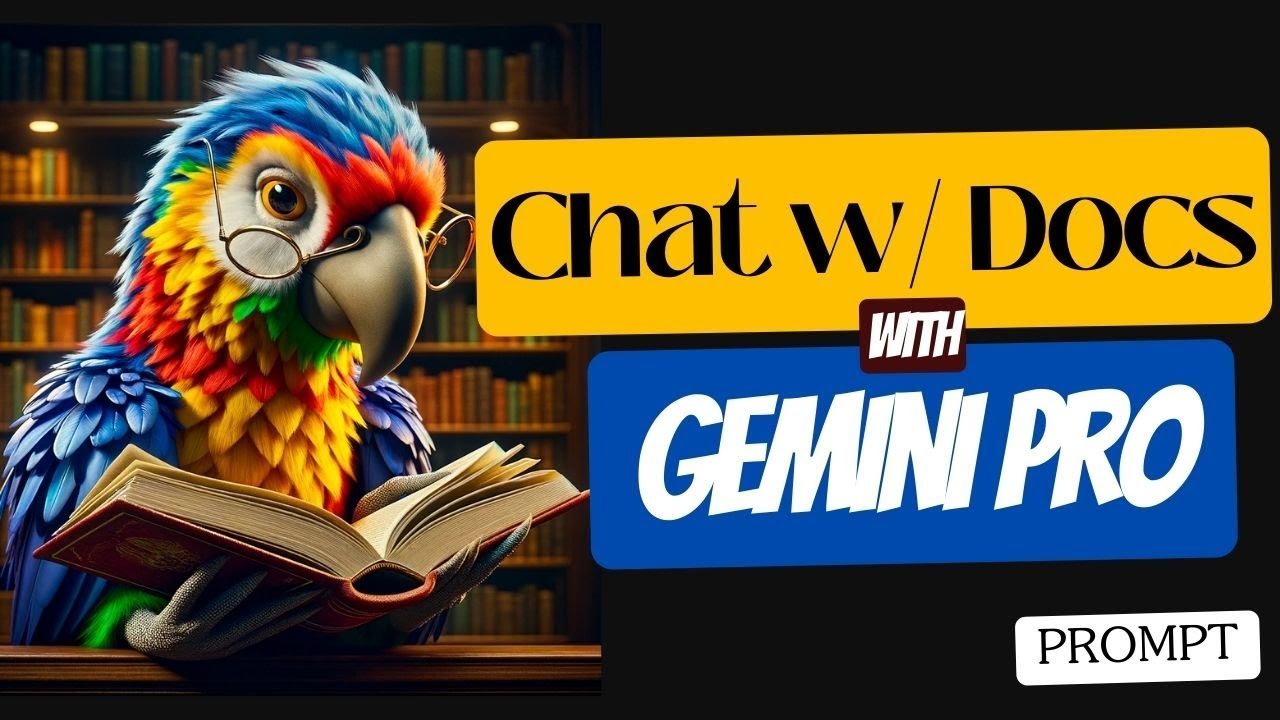

FileUpload(value=(), accept='.pdf', description='Upload', multiple=True)

Text(value='', description='Your Question:', placeholder='Ask a Question from the PDF Files')

Button(description='Submit & Process', style=ButtonStyle())

Output()

In [35]:
from IPython.display import display, Image, HTML
import ipywidgets as widgets
from PyPDF2 import PdfReader
import io

def create_widgets():
    # Create widgets for PDF upload and user input
    pdf_uploader = widgets.FileUpload(
        accept='.pdf',  # Accept only PDF files
        multiple=True   # Allow multiple file uploads
    )

    user_question = widgets.Text(
        value='',
        placeholder='Ask a Question from the PDF Files',
        description='Your Question:',
        disabled=False
    )

    submit_button = widgets.Button(description="Submit & Process")

    # Create an output widget to display results
    output = widgets.Output()

    return pdf_uploader, user_question, submit_button, output

def read_pdfs(pdf_files):
    text = ""
    for file_info in pdf_files:
        pdf_content = io.BytesIO(file_info['content'])
        pdf_reader = PdfReader(pdf_content)
        for page in pdf_reader.pages:
            text += page.extract_text()
    return text

def on_button_click(pdf_uploader, user_question, output):
    with output:
        output.clear_output()
        if user_question.value and pdf_uploader.value:
            # Extract file info from the uploader
            if isinstance(pdf_uploader.value, dict):
                pdf_files = list(pdf_uploader.value.values())  # Extract file info from dictionary
            else:
                pdf_files = pdf_uploader.value  # Assuming it's already in list format

            raw_text = read_pdfs(pdf_files)
            # Placeholder for further processing with raw_text
            display(HTML(f"<b>Reply:</b> {user_question.value}<br><br>Processed Text:<br>{raw_text[:1000]}..."))  # Display first 1000 chars of processed text

def main():
    # Display image
    display(Image(filename="../assets/langchain.jpg"))

    # Display header
    display(HTML("<h1>Chat About Intelligent Agents using Gemini💁</h1>"))

    # Create and display widgets
    pdf_uploader, user_question, submit_button, output = create_widgets()
    display(pdf_uploader)
    display(user_question)
    display(submit_button)
    display(output)

    # Attach event handler to button
    submit_button.on_click(lambda b: on_button_click(pdf_uploader, user_question, output))

if __name__ == "__main__":
    main()
